In [2]:
! wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE123nnn/GSE123813/suppl/GSE123813%5Fbcc%5FscRNA%5Fcounts.txt.gz

--2024-08-06 13:03:02--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE123nnn/GSE123813/suppl/GSE123813%5Fbcc%5FscRNA%5Fcounts.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.10, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105220738 (100M) [application/x-gzip]
Saving to: ‘GSE123813_bcc_scRNA_counts.txt.gz’

GSE123813_bcc_scRNA 100%[===================>] 100.35M  13.1MB/s    in 15s     

2024-08-06 13:03:19 (6.63 MB/s) - ‘GSE123813_bcc_scRNA_counts.txt.gz’ saved [105220738/105220738]



In [2]:
! gunzip GSE123813_bcc_scRNA_counts.txt.gz

In [3]:
import pandas as pd
import scanpy as sc
import numpy as np

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-08-06 13:03:30.001033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 13:03:31.162678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.13


In [4]:
adata = (sc.read_csv("GSE123813_bcc_scRNA_counts.txt", first_column_names=True, delimiter ="\t"))

In [5]:
ad = adata.transpose()

In [6]:
ad.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
ad

AnnData object with n_obs × n_vars = 53030 × 23309

normalizing counts per cell
    finished (0:00:03)


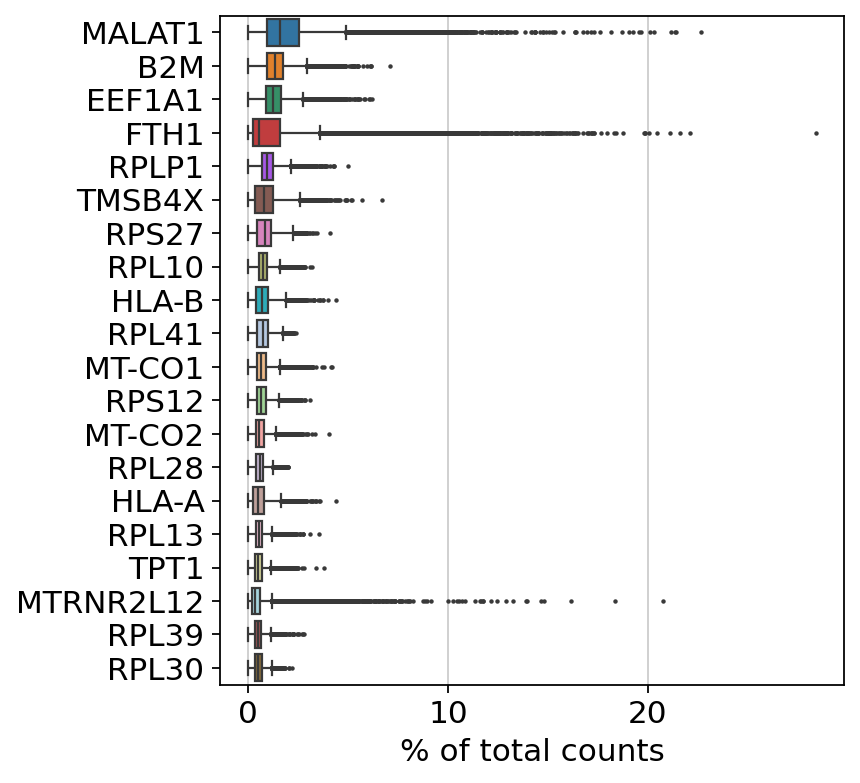

In [8]:
sc.pl.highest_expr_genes(ad, n_top=20)

In [9]:
adata = ad
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 348 genes that are detected in less than 3 cells


In [1]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

NameError: name 'adata' is not defined

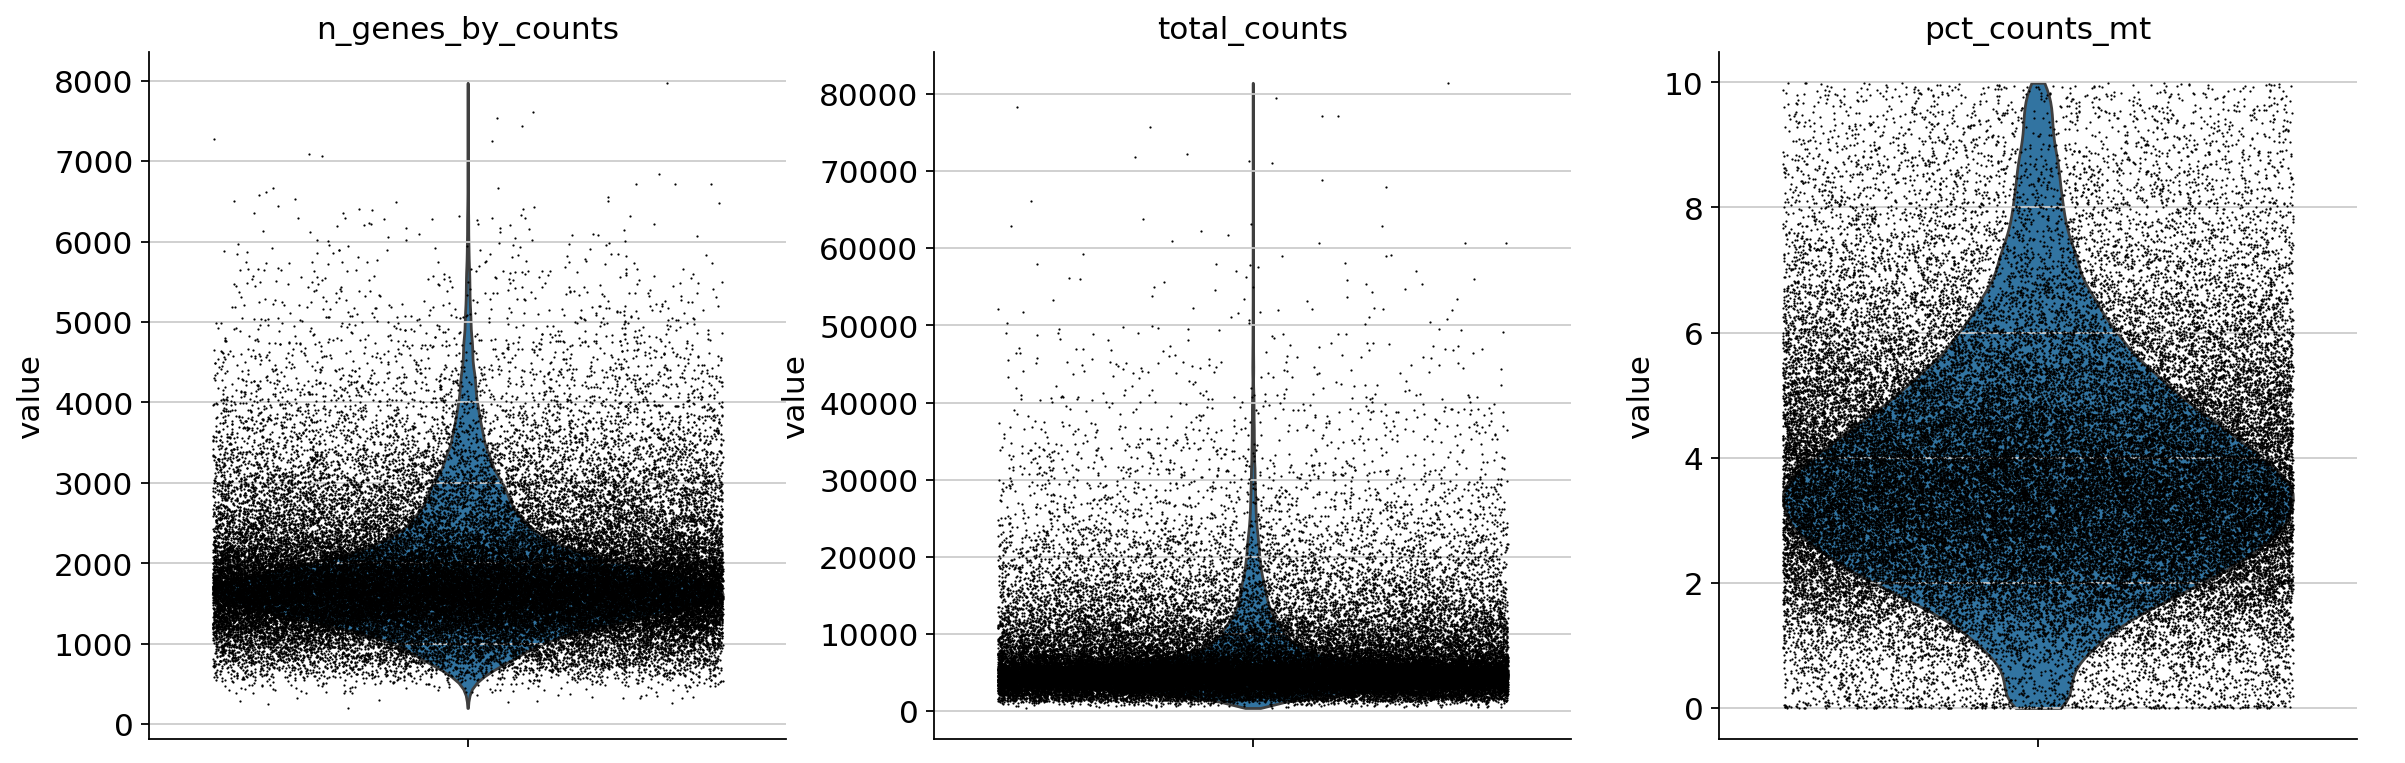

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

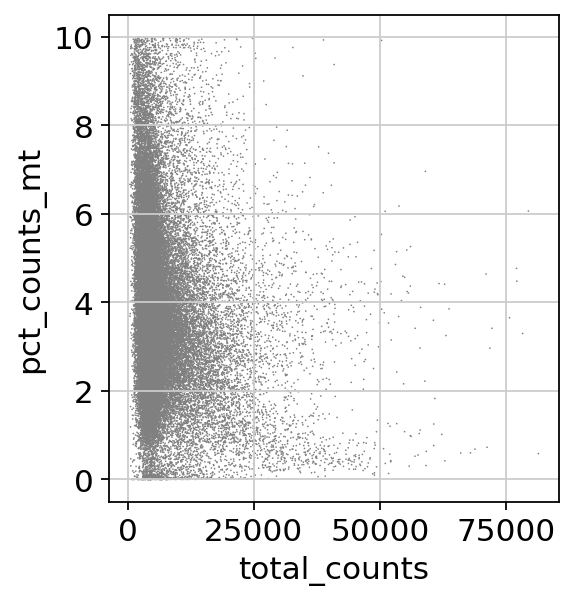

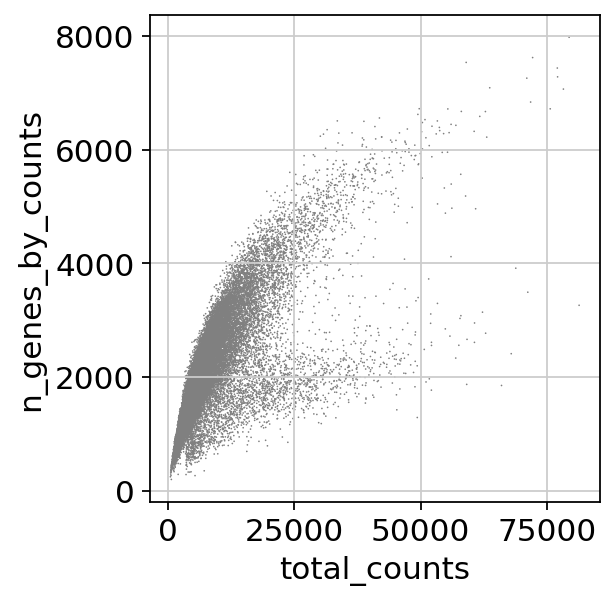

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


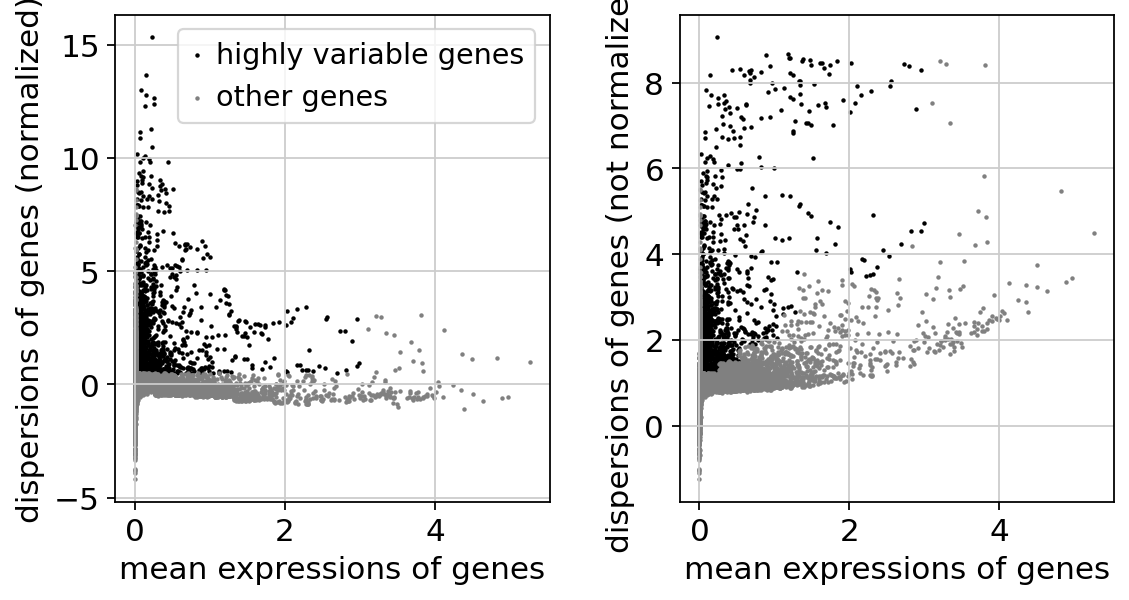

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']


/opt/jupyterhub/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:40)


In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:09)


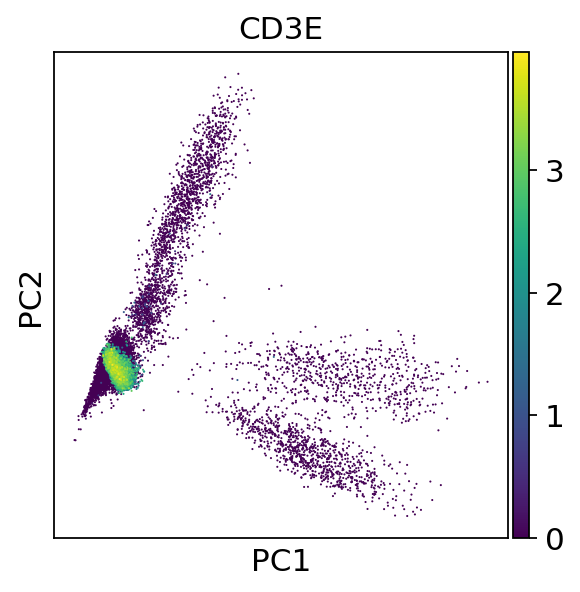

In [25]:
sc.pl.pca(adata, color="CD3E")

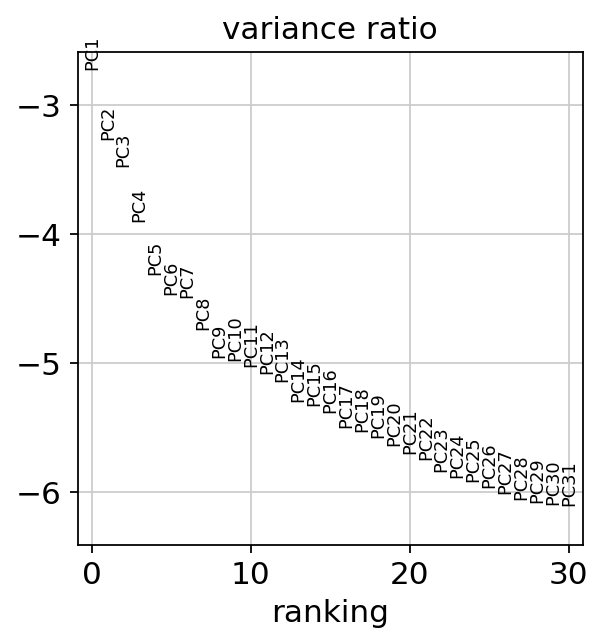

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
result_file = "BCC.5had"

In [29]:
adata.write(result_file)

In [30]:
adata

AnnData object with n_obs × n_vars = 34168 × 1565
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)

computing neighbors
    using 'X_pca' with n_pcs = 12
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)


In [33]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


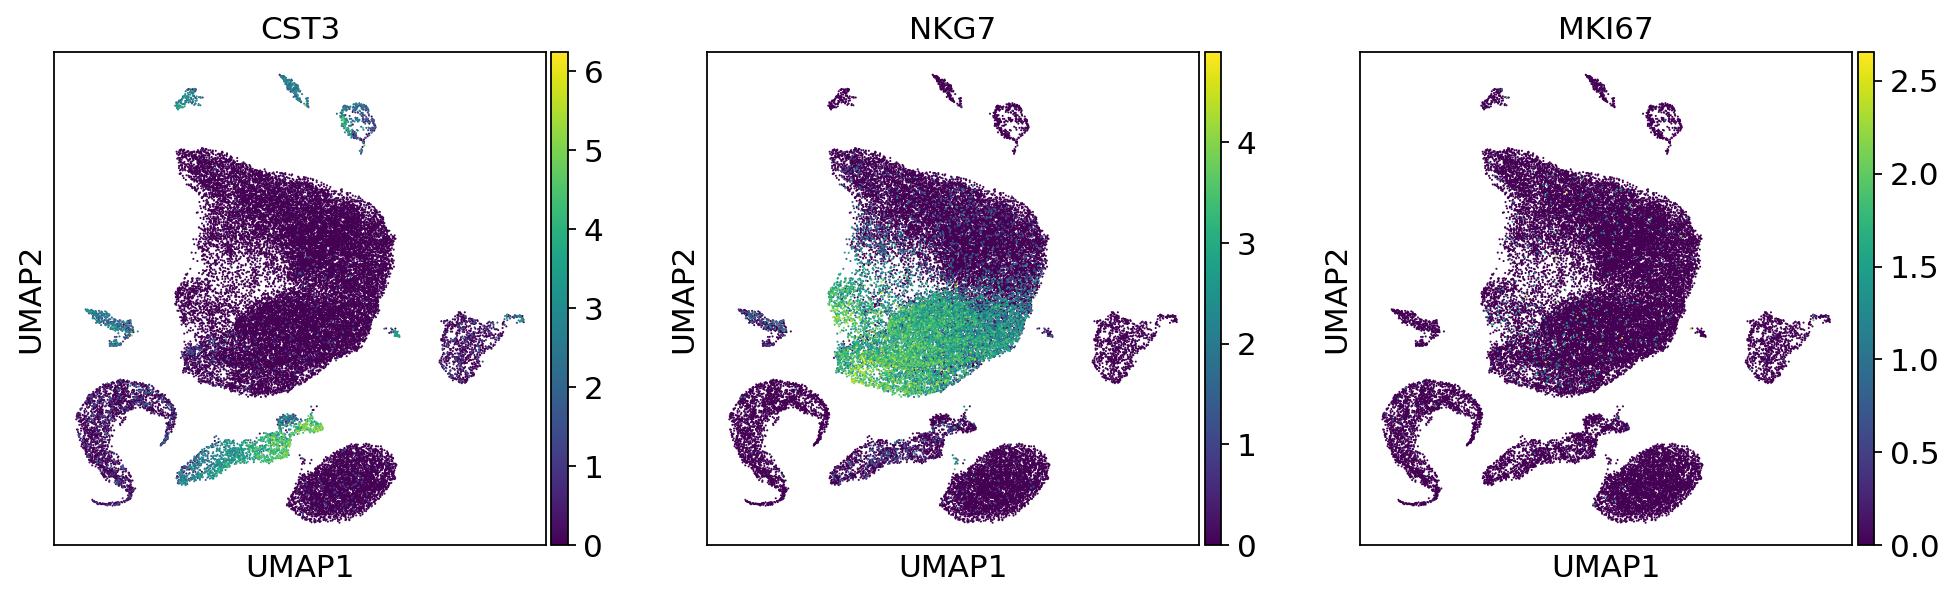

In [35]:
sc.pl.umap(adata, color=["CST3", "NKG7", "MKI67"])

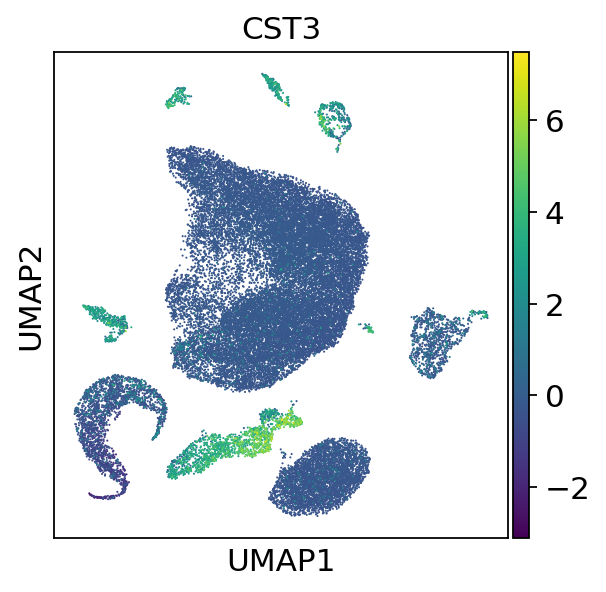

In [38]:
sc.pl.umap(adata, color=["CST3"], use_raw=False)

In [41]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [44]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:17)


/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usu

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


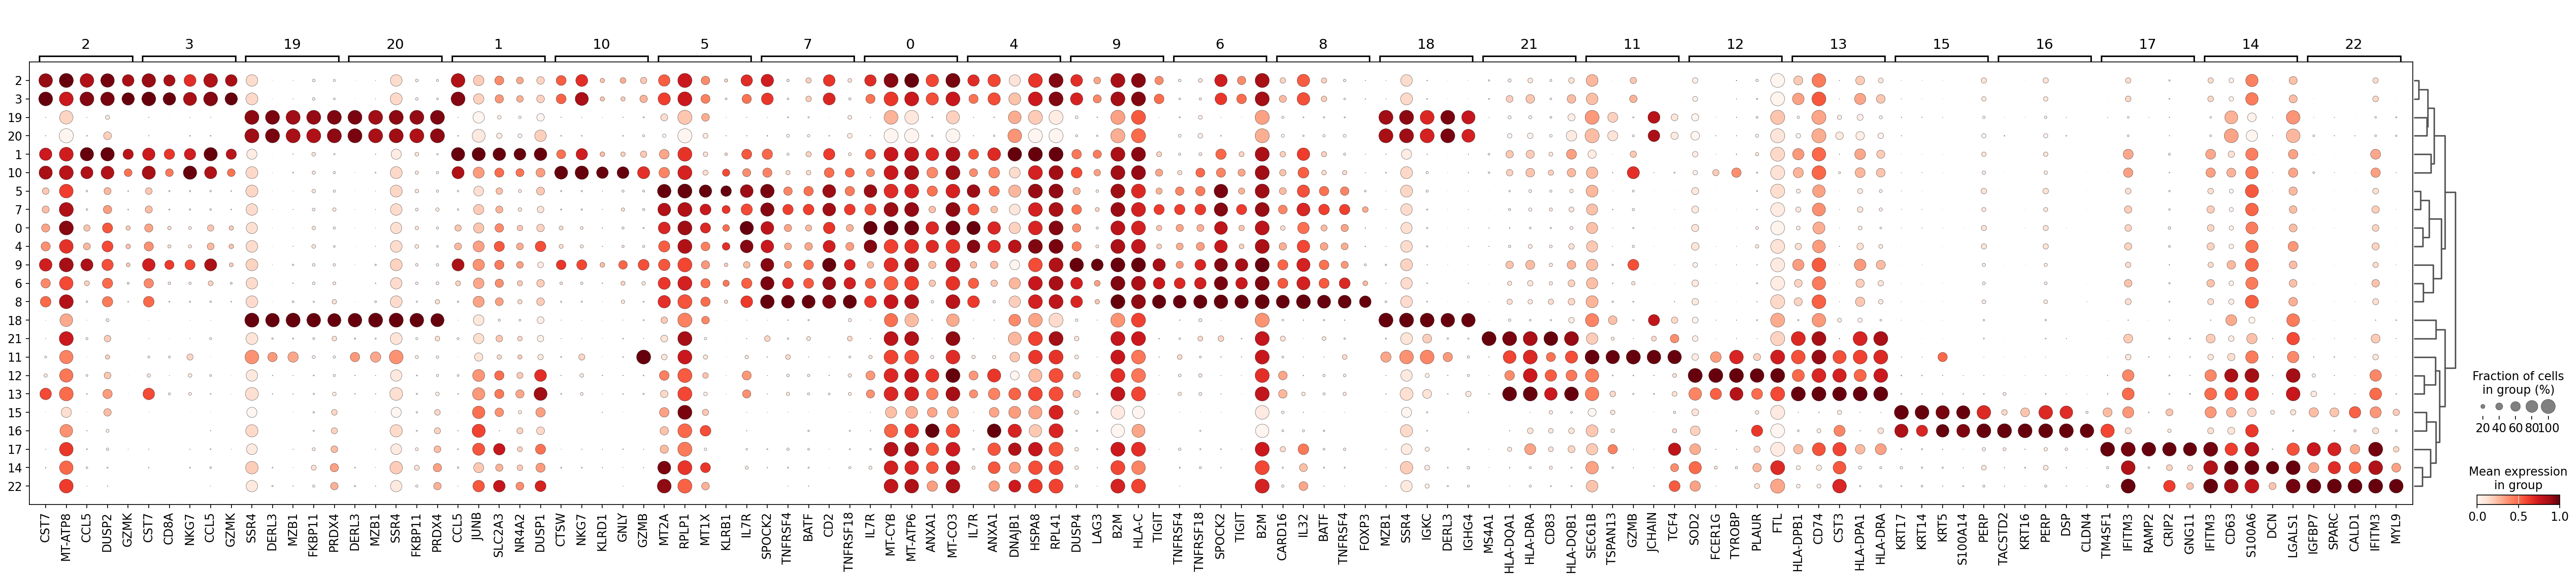

In [46]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

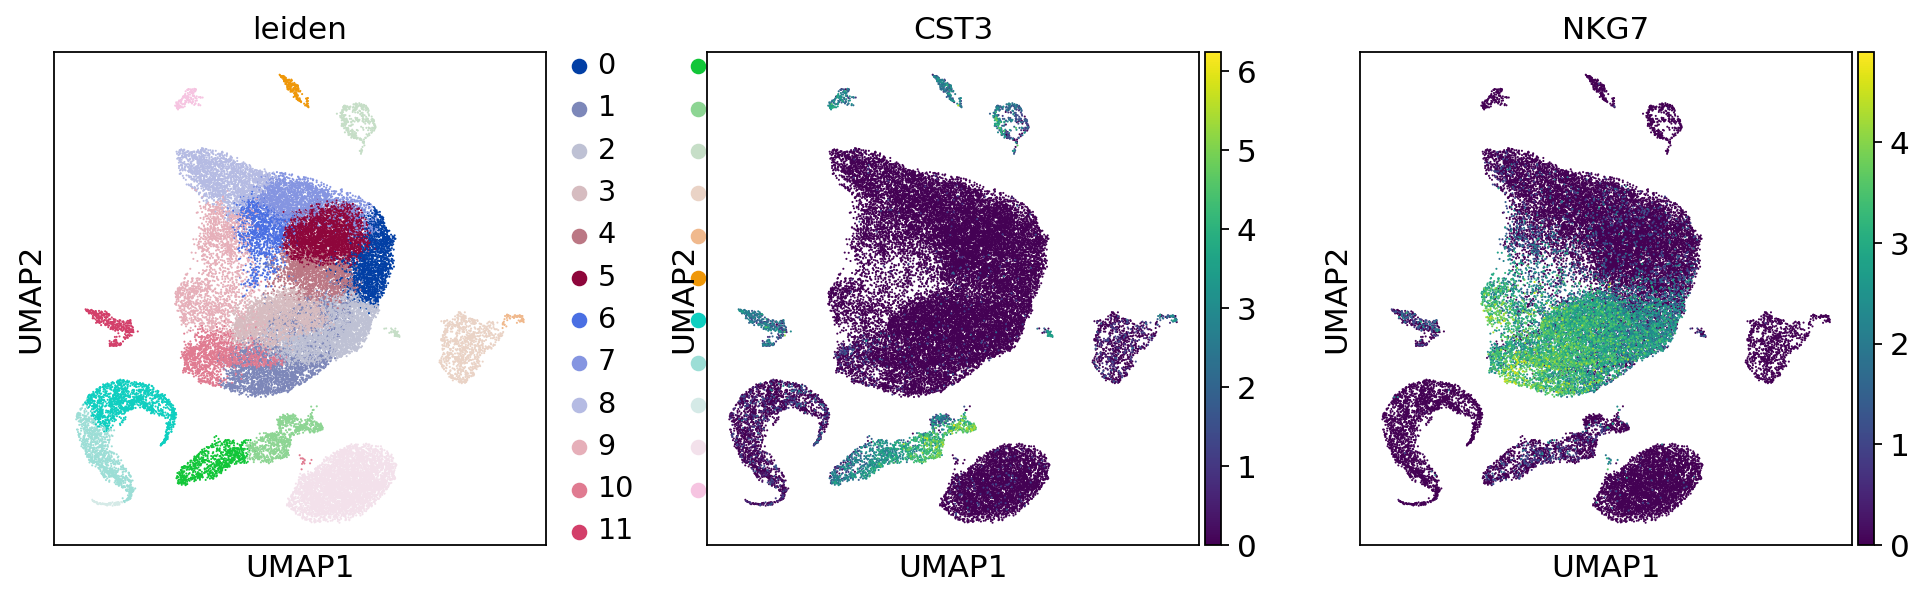

In [47]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [48]:
adata.write(result_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:41)


/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usu

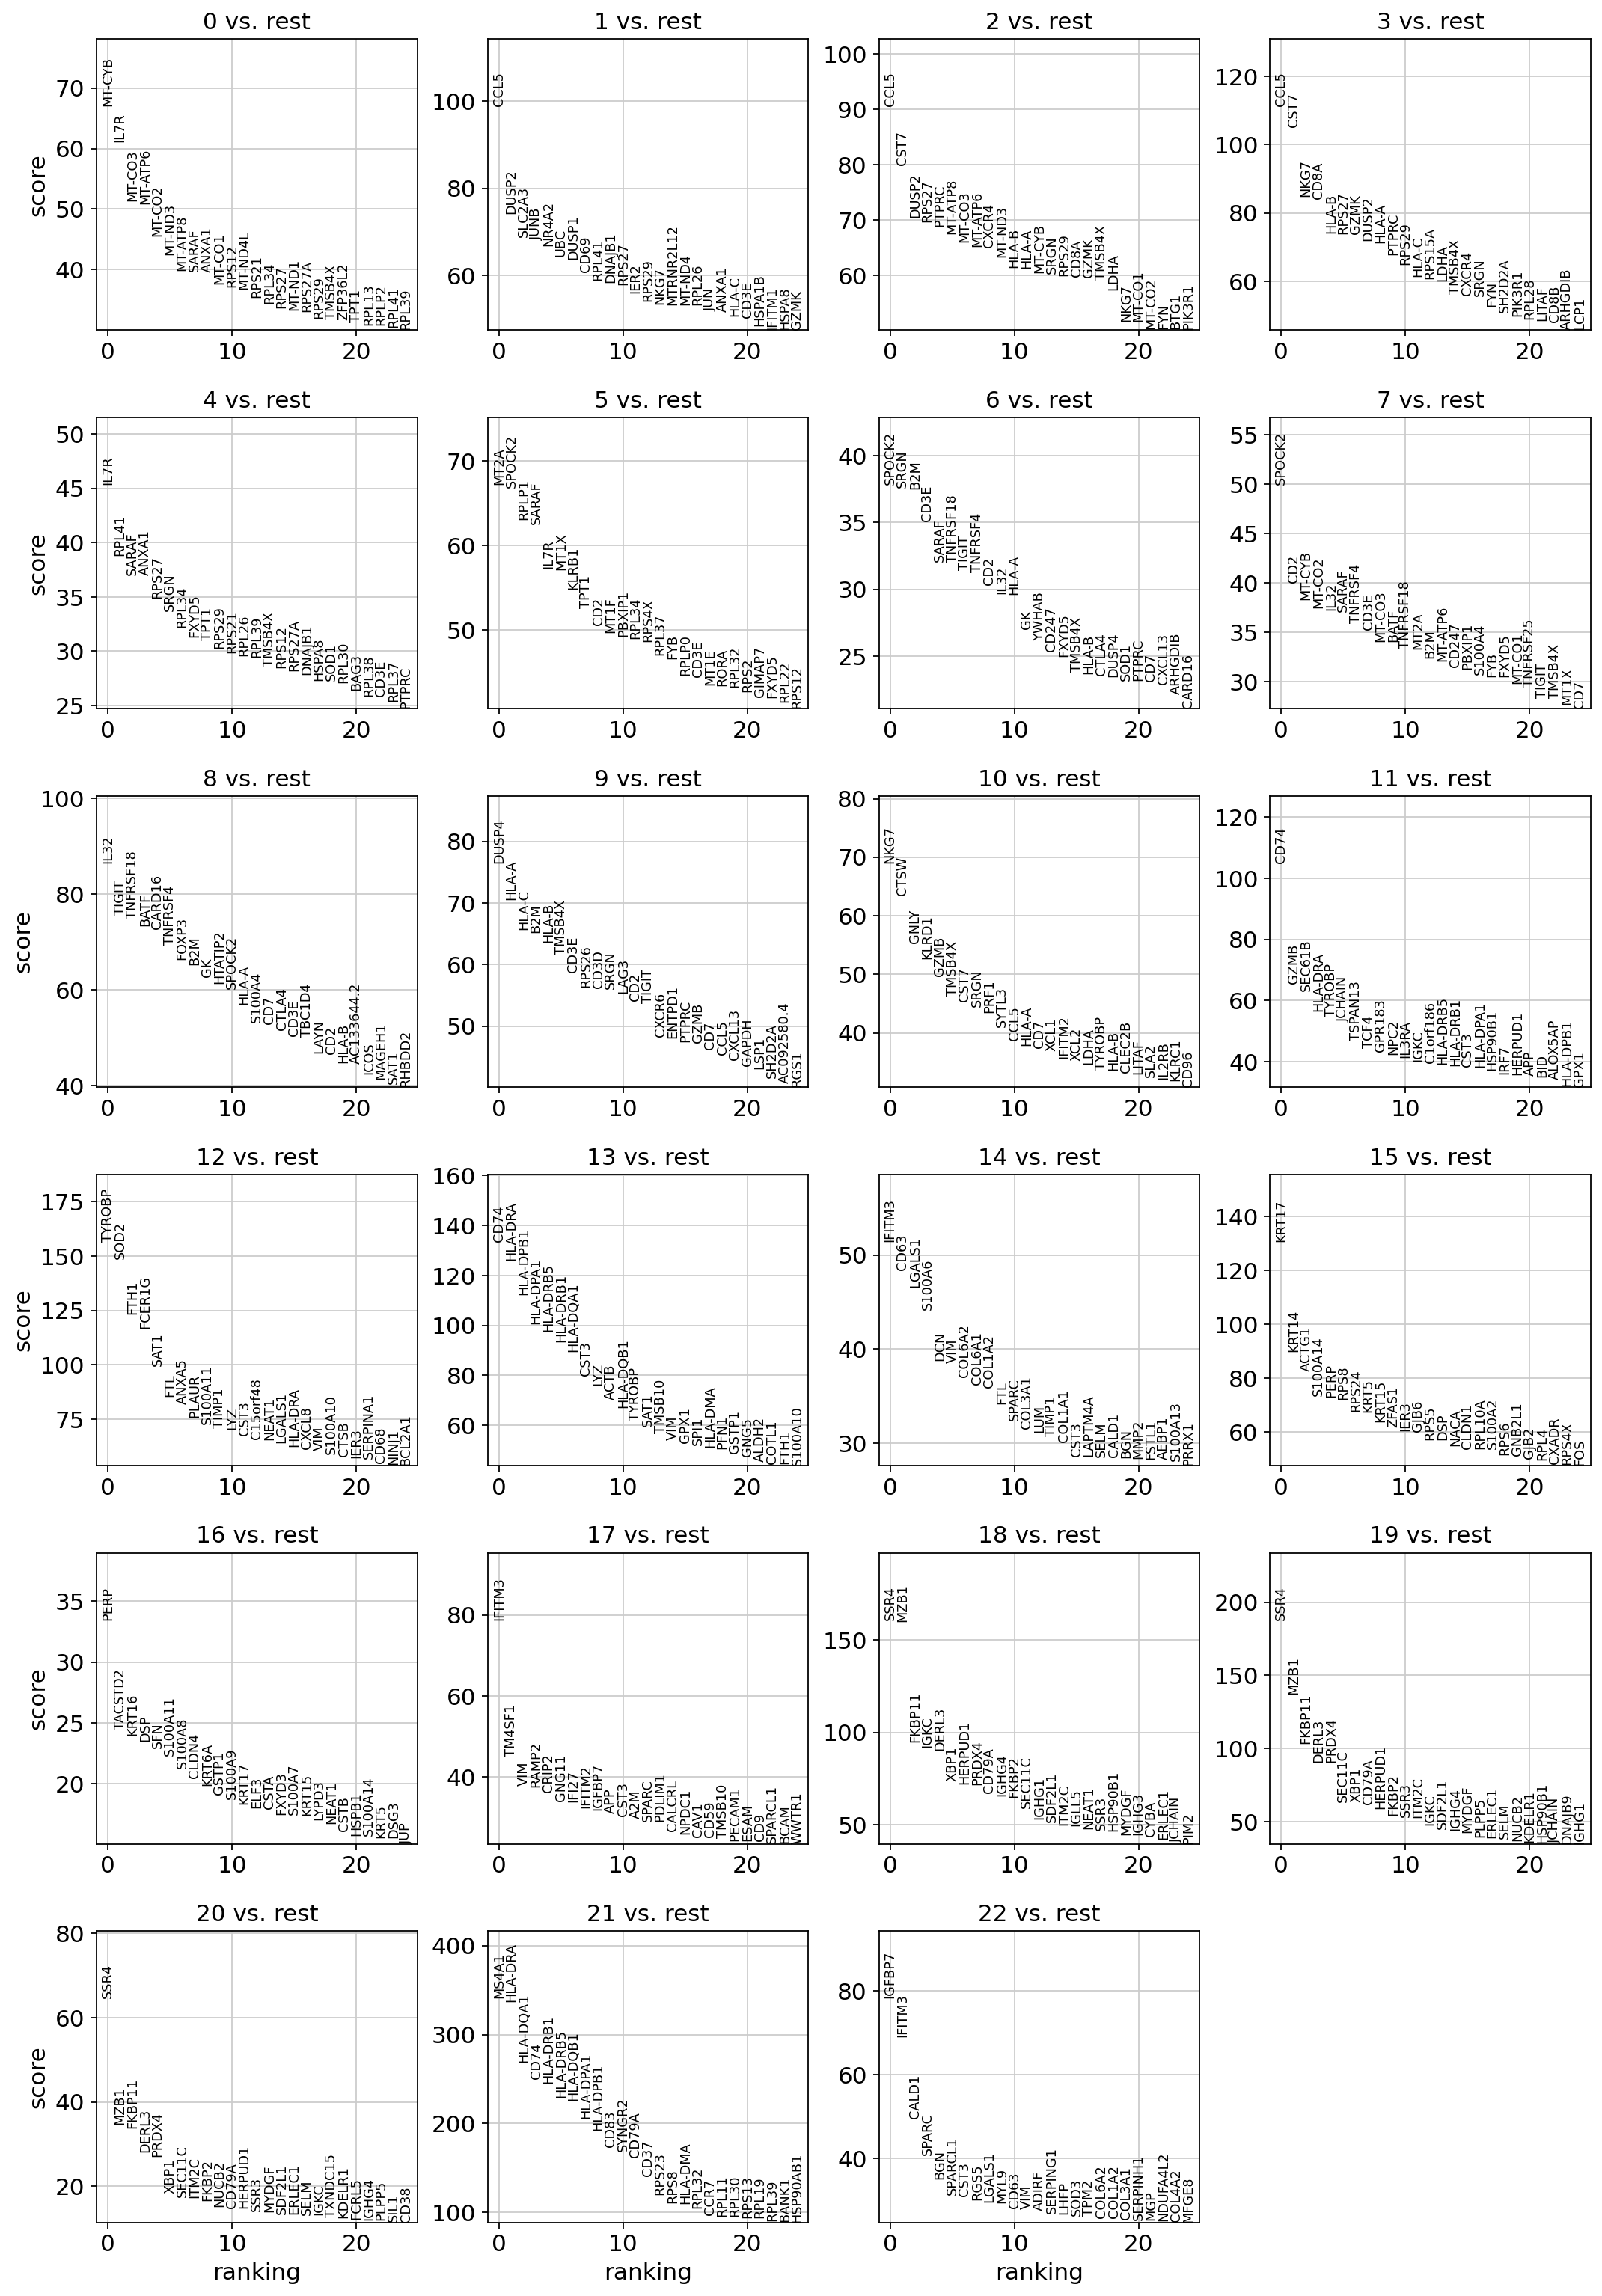

In [49]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:01:17)


/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usu

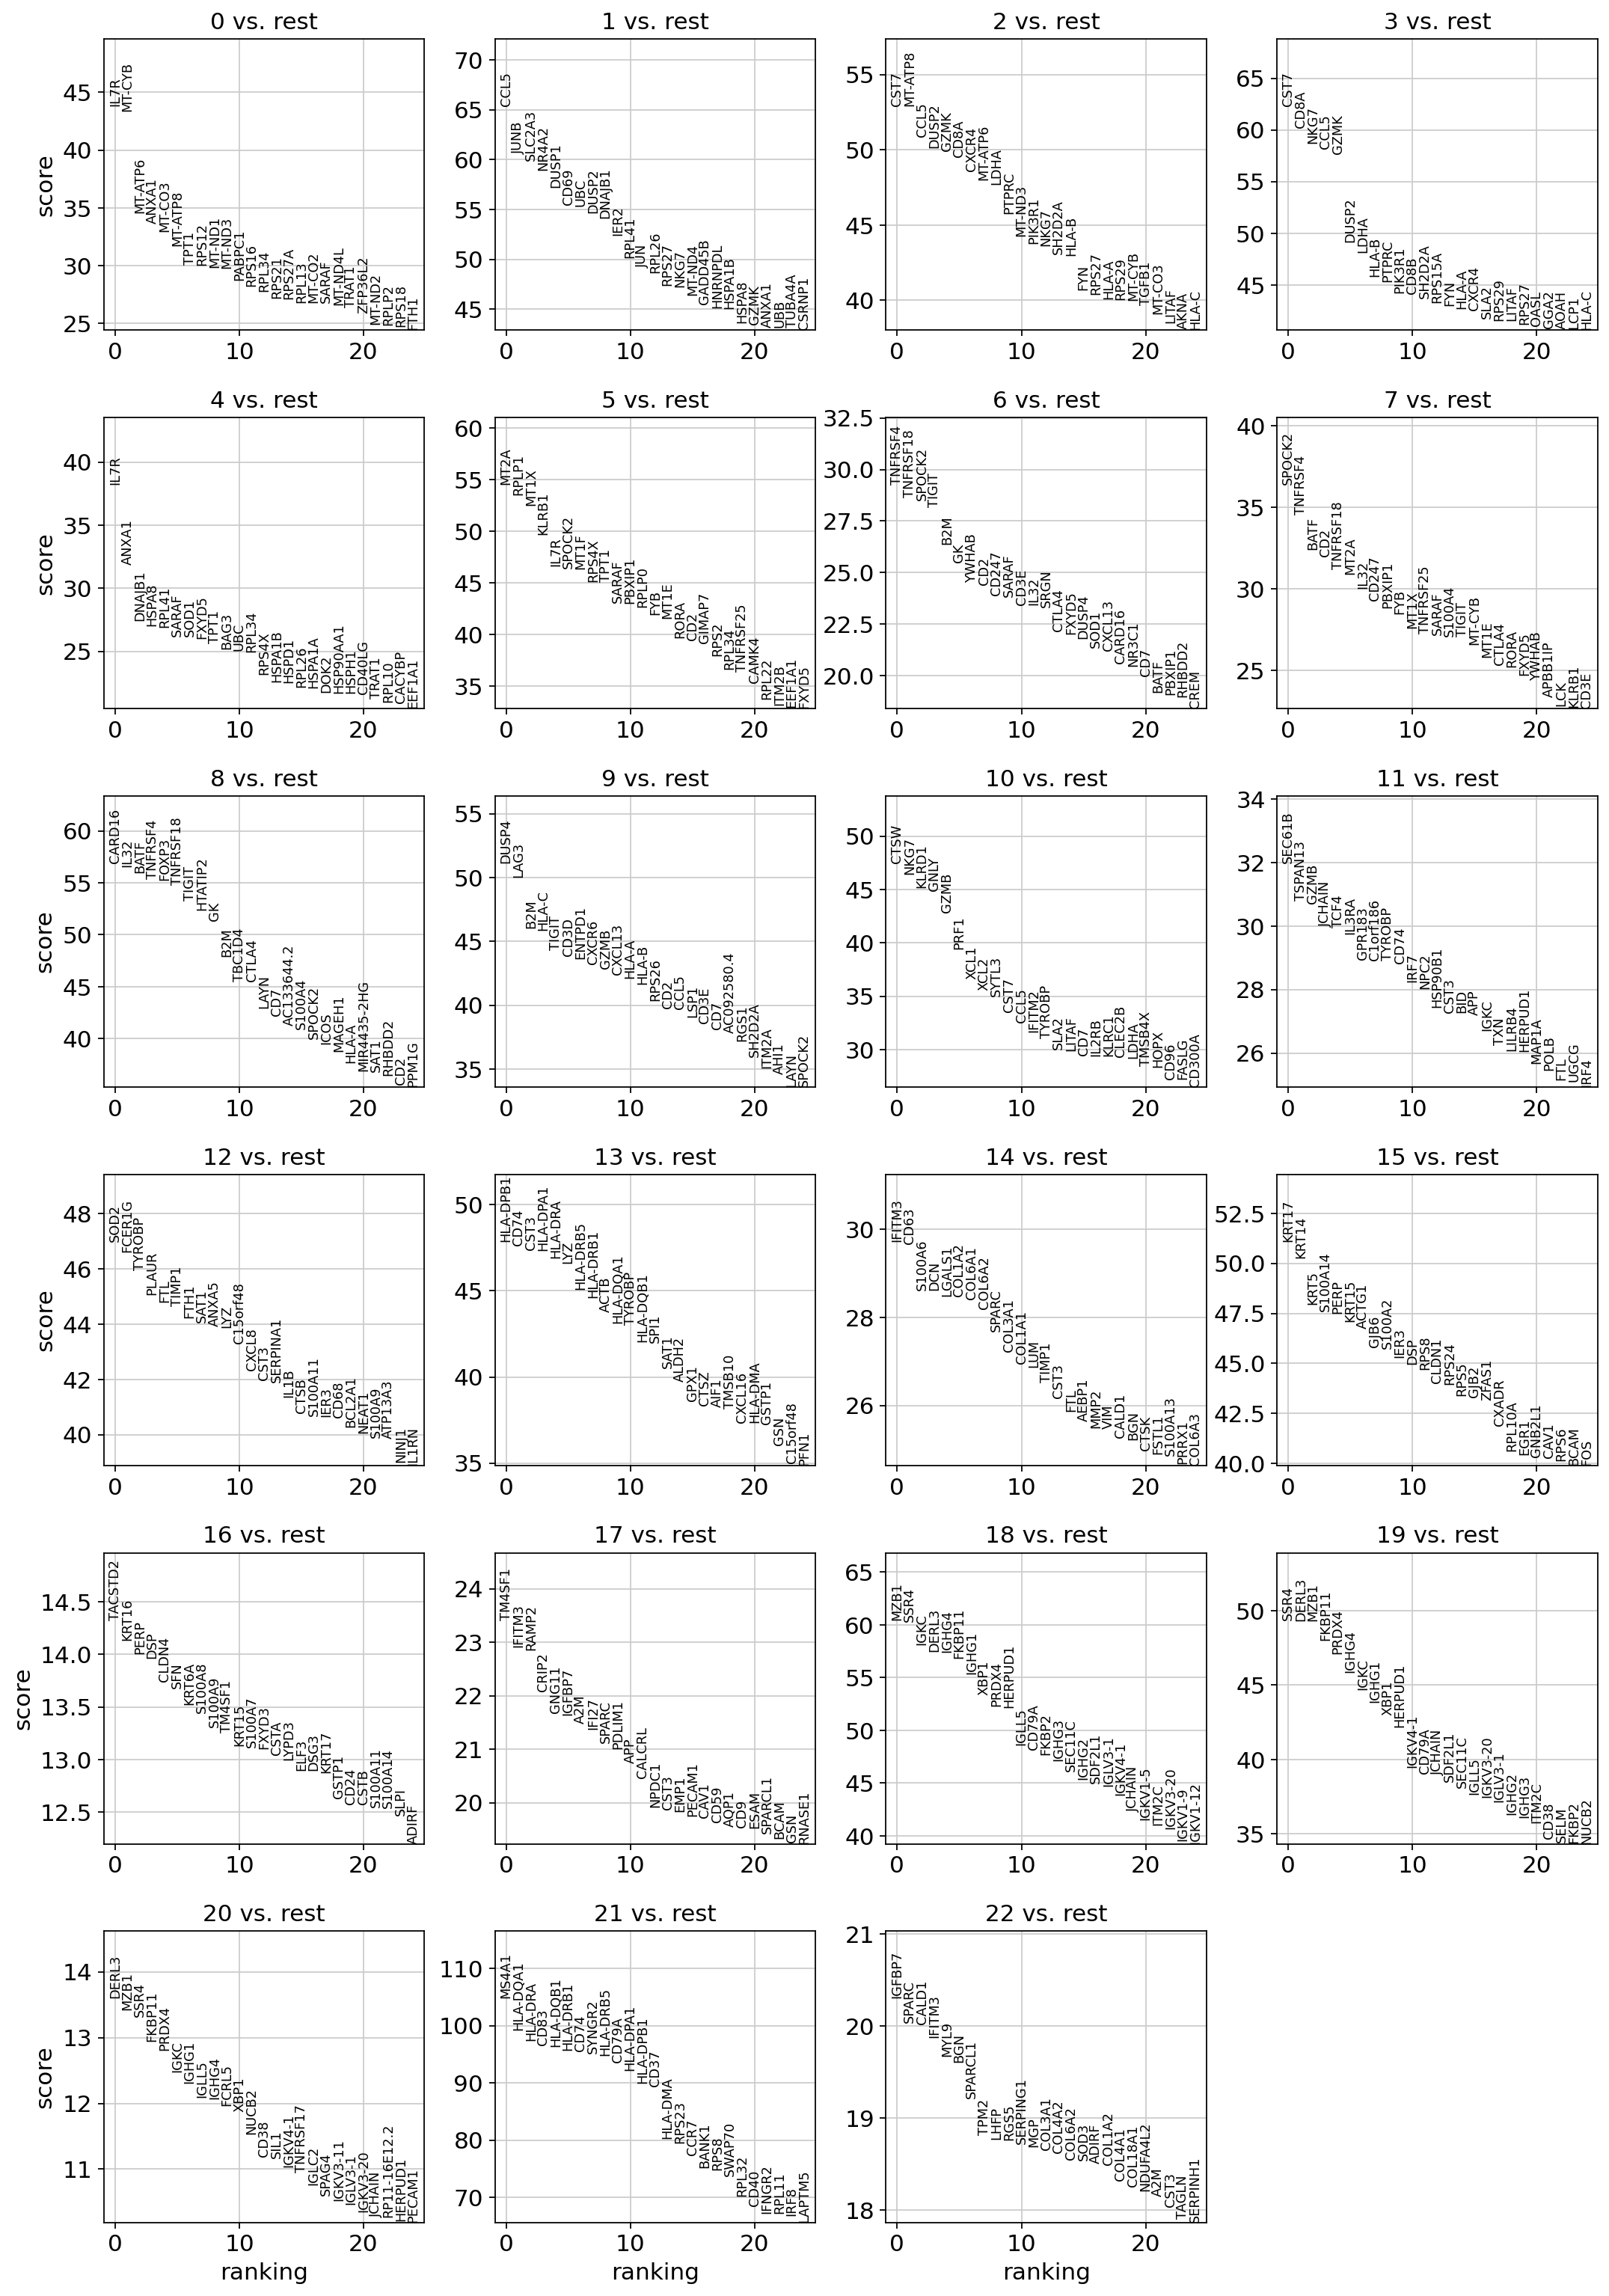

In [51]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [52]:
adata.write(result_file)

ranking genes
    finished (0:03:34)


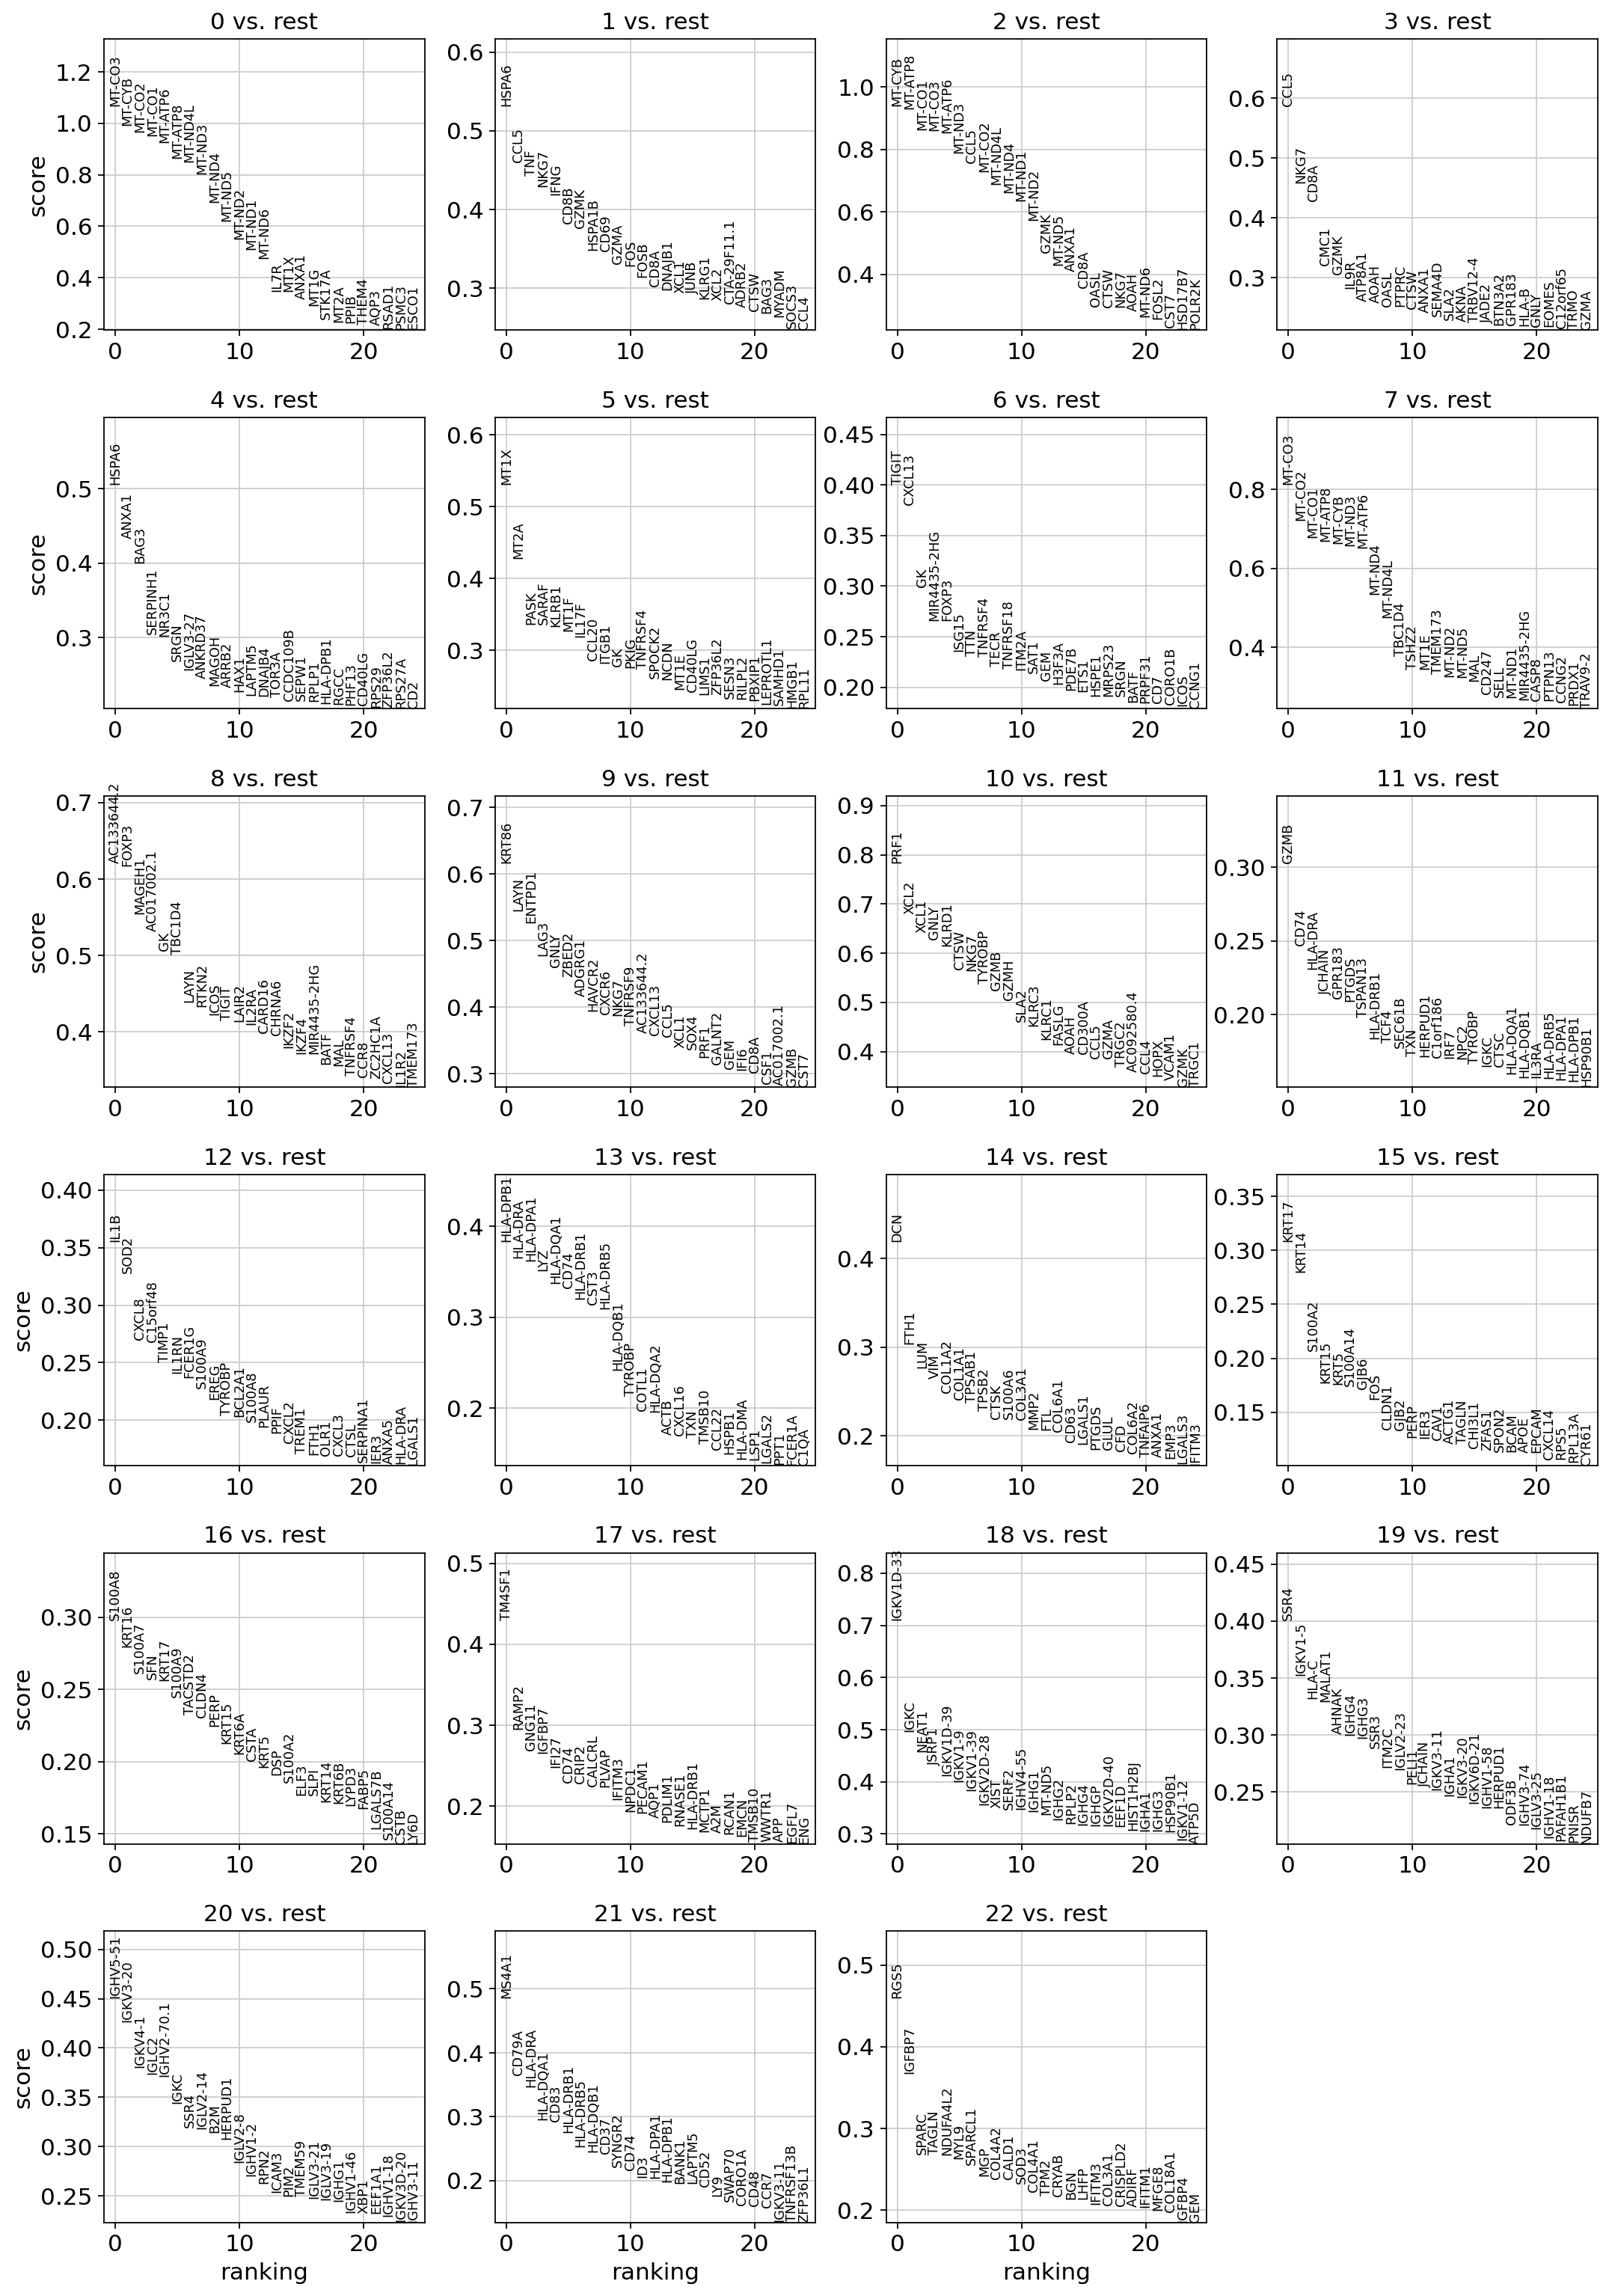

In [53]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [54]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [71]:

pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

3
0  SH2D2A
1   HLA-A
2    SLA2
3   HLA-B
4    CD8A

In [63]:
result = adata.uns["rank_genes_groups"]
result
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "scores"]
    }
).head(5)

0_n       0_s    1_n       1_s      2_n       2_s   3_n       3_s  \
0   MT-CO3  1.066393  HSPA6  0.531149   MT-CYB  0.938510  CCL5  0.586499   
1   MT-CYB  0.991859   CCL5  0.460387  MT-ATP8  0.930113  NKG7  0.457269   
2   MT-CO2  0.964625    TNF  0.443150   MT-CO1  0.862103  CD8A  0.428252   
3   MT-CO1  0.949598   NKG7  0.428331   MT-CO3  0.860789  CMC1  0.320464   
4  MT-ATP6  0.923629   IFNG  0.418332  MT-ATP6  0.851572  GZMK  0.304953   

        4_n       4_s  ...       18_n      18_s     19_n      19_s  \
0     HSPA6  0.505377  ...  IGKV1D-33  0.710241     SSR4  0.400876   
1     ANXA1  0.432996  ...       IGKC  0.495696  IGKV1-5  0.352098   
2      BAG3  0.399480  ...      NEAT1  0.456469    HLA-C  0.331651   
3  SERPINH1  0.304299  ...      JSRP1  0.431549   MALAT1  0.328893   
4     NR3C1  0.300973  ...  IGKV1D-39  0.411178    AHNAK  0.300834   

         20_n      20_s      21_n      21_s      22_n      22_s  
0    IGHV5-51  0.450228     MS4A1  0.485073      RGS5  0.459087  
1    IGKV3-20  0.425970     CD79A  0.365033    IGFBP7  0.366662  
2     IGKV4-1  0.380172   HLA-DRA  0.345713     SPARC  0.267671  
3       IGLC2  0.373210  HLA-DQA1  0.294640     TAGLN  0.267555  
4  IGHV2-70.1  0.370458      CD83  0.292475  NDUFA4L2  0.266764  

[5 rows x 46 columns]

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'logreg',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MT-CO3', 'HSPA6', 'MT-CYB', 'CCL5', 'HSPA6', 'MT1X', 'TIGIT', 'MT-CO3', 'AC133644.2', 'KRT86', 'PRF1', 'GZMB', 'IL1B', 'HLA-DPB1', 'DCN', 'KRT17', 'S100A8', 'TM4SF1', 'IGKV1D-33', 'SSR4', 'IGHV5-51', 'MS4A1', 'RGS5'),
            ('MT-CYB', 'CCL5', 'MT-ATP8', 'NKG7', 'ANXA1', 'MT2A', 'CXCL13', 'MT-CO2', 'FOXP3', 'LAYN', 'XCL2', 'CD74', 'SOD2', 'HLA-DRA', 'FTH1', 'KRT14', 'KRT16', 'RAMP2', 'IGKC', 'IGKV1-5', 'IGKV3-20', 'CD79A', 'IGFBP7'),
            ('MT-CO2', 'TNF', 'MT-CO1', 'CD8A', 'BAG3', 'PASK', 'GK', 'MT-CO1', 'MAGEH1', 'ENTPD1', 'XCL1', 'HLA-DRA', 'CXCL8', 'HLA-DPA1', 'LUM', 'S100A2', 'S100A7', 'GNG11', 'NEAT1', 'HLA-C', 'IGKV4-1', 'HLA-DRA', 'SPARC'),
            ...,
            ('HLA-DPA1', 'TYROBP', 'HLA-DRA', 'MT-CO1', 'MT-CO2', 'MT-ND3', 'MT-ATP8', 'CST7', 'GZMA', 'FTH1', 'CD6', 'IL32', 'CST7', 'MT

ranking genes
    finished (0:00:11)


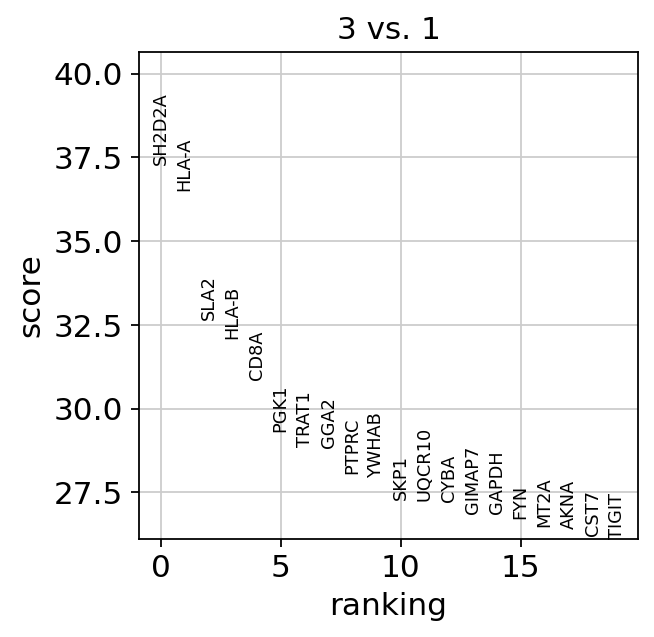

In [66]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["3"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["3"], n_genes=20)

/opt/jupyterhub/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


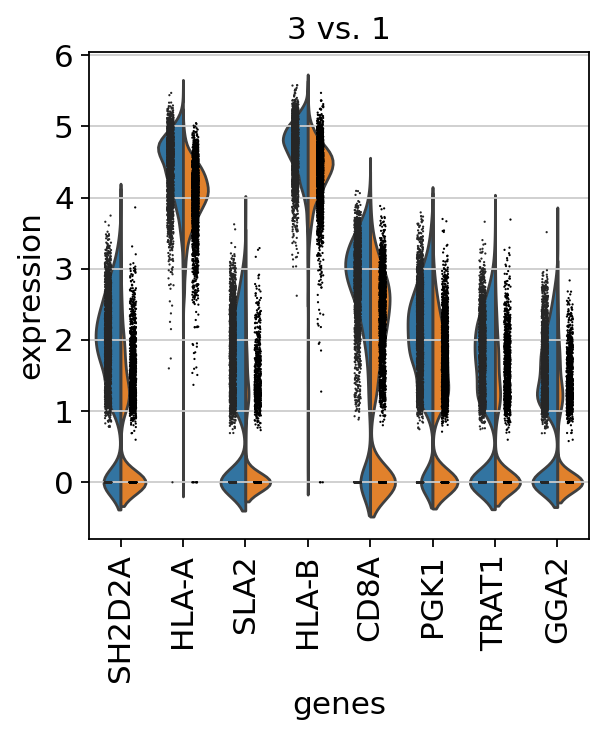

In [67]:
sc.pl.rank_genes_groups_violin(adata, groups="3", n_genes=8)

/opt/jupyterhub/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


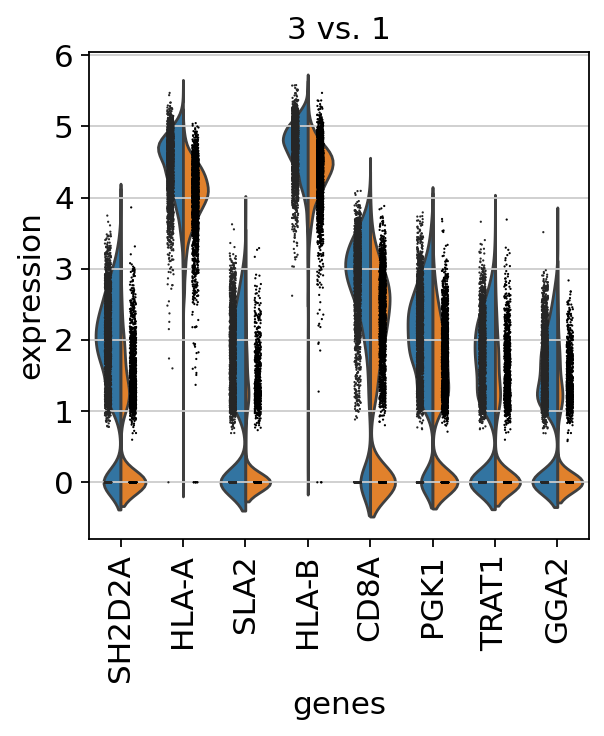

In [68]:
sc.pl.rank_genes_groups_violin(adata, groups="3", n_genes=8)

In [ ]:

pd.pivot_table(obs_df,  values = "n_genes", index = ("leiden"), aggfunc="count", columns = "predicted.celltype.l2", margins_name="Totals", margins=True, dropna=False, fill_value="NA", observed=False)